In [3]:
from keras.layers.convolutional import ZeroPadding2D
from keras.utils import np_utils
from keras.models import load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import optimizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from PIL import Image, ImageDraw
import cv2
from sklearn.utils import shuffle
%matplotlib inline
! pip install pydrive

    100% |████████████████████████████████| 993kB 20.3MB/s 
  Running setup.py bdist_wheel for pydrive ... - done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


# Loading Data

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass


file_list = drive.ListFile(
    {'q': "'1GiITmsHYBfeGth-LTfnXpd6524D4-uDm' in parents"}).GetList()


In [11]:
i =1
for f in file_list:
  i = i+1
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  # print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)
  if i ==20:
    break


title: bench.csv, id: 1dYztgciO88Z_kI12edZdLCtrQR9VLfbI
title: shovel.csv, id: 1zvhytLDcfqY7uA3y_Ot5YKxBica9Dw8D
title: screwdriver.csv, id: 1VQNK5KowUhRtujJfwW7BvO91F-waYW2i
title: piano.csv, id: 1Guz55mbo1cDM3ZWt3u-Mlw0FGyfKKZZQ
title: crayon.csv, id: 1Daw8Jvx7yG7JN3pa29sI_eZqzHTLaKOQ
title: submarine.csv, id: 1C2oWsVO7L93Wsx5uGSeykzzje6gIcGKf
title: bee.csv, id: 1KWyha2KzZG6di60nm2AnL3d67d8IFMqz
title: octopus.csv, id: 1KMMl0cHt5cuNfd6G2bkQKFGb4RhaJfsT
title: duck.csv, id: 1qAnS2uA-t9M53iRMfavPEdtuml6Vax_N
title: hot dog.csv, id: 1j9fdQR3NLwhHJ5ai0h8lsAnwJKqYmROO
title: shorts.csv, id: 1N1HKB8OmOUg0JWwwH5OzSZMpw5VHW6bq
title: knee.csv, id: 1OE-DfWB_THcZvgyxeARYsvlZjEcc8VD_
title: line.csv, id: 1TLU5cASyMVyCozDH2hKV9gktBNmZc23k
title: wristwatch.csv, id: 1ZblFCaKa9kZpZy_A6i-7q1lNgxoq7uHt
title: cannon.csv, id: 1cNwslYH5l_owQlhUbVSjB5_AHfK_Wl33
title: purse.csv, id: 1GTtbzawBvPXEt53W_Jatj9c_Zjd4Xjss
title: cat.csv, id: 1uuzEsCOGhgsvOxJlfAqPlJVH3gTKSPZS
title: wheel.csv, id: 1KRiCErdmS

#Helper Functions


In [0]:
def plot_metrics_primary(acc, val_acc, loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(20,7))

    ax1.plot(acc, label='Train Accuracy')
    ax1.plot(val_acc, label='Validation accuracy')
    ax1.legend(loc='best')
    ax1.set_title('Accuracy')

    ax2.plot(loss, label='Train loss')
    ax2.plot(val_loss, label='Validation loss')
    ax2.legend(loc='best')
    ax2.set_title('Loss')

    plt.xlabel('Epochs')
   

def plot_confusion_matrix(cnf_matrix, labels): 
    cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
    plt.figure(figsize=(20,7))
    sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
    plt.show()
    
# Function to plot images.
def plot_image(image_array):
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, frameon=False)
    ax2.imshow(image_array)
    plt.axis('off')
    plt.show()

#sample_1 = test['drawing_np'].values[0]
#plot_image(sample_1)

#Params


In [0]:
# Model parameters
BATCH_SIZE = 64
EPOCHS = 15
LEARNING_RATE = 0.001
HEIGHT = 28
WIDTH = 28
CHANNEL = 1

##Reading Data


In [100]:
TRAIN_PATH = '/root/data/'
TEST_PATH = '../input/test_simplified.csv'
SUBMISSION_NAME = 'submission.csv'
n_cat = 20

train = pd.DataFrame()
for file in os.listdir(TRAIN_PATH):
    train = train.append(pd.read_csv(TRAIN_PATH + file, usecols=[1, 5], nrows=5000))
# Shuffle dat
train = shuffle(train, random_state=123)
print(len(train))
print(list(train))

95000


In [102]:
#Fixing labels.
train['word'] = train['word'].replace(' ', '_', regex=True)
# Get labels and one-hot encode them.
classes_names = train['word'].unique()
print(classes_names)
labels = pd.get_dummies(train['word']).values
train.drop(['word'], axis=1, inplace=True)
N_CLASSES = len(classes_names)



['bee' 'cat' 'crayon' 'bench' 'shorts' 'wheel' 'hot_dog' 'wristwatch'
 'submarine' 'octopus' 'shovel' 'beach' 'cannon' 'purse' 'duck'
 'screwdriver' 'line' 'knee' 'piano']


In [0]:
# Transform drawing into numpy arrays
train['drawing_np'] = train['drawing'].apply(drawing_to_np)
# Reshape arrays
train_drawings = np.asarray([x.reshape(HEIGHT, WIDTH, CHANNEL) for x in train['drawing_np'].values])
print(train_drawings.shape)

In [1]:
x_train, x_val, y_train, y_val = train_test_split(train_drawings, labels, test_size= 0.2, random_state=1)
print(y_train.shape)

NameError: ignored

# Model


In [68]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(5,5),padding='Same', activation='relu', input_shape=(HEIGHT, WIDTH, CHANNEL)))
model.add(Conv2D(32, kernel_size=(5,5),padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3),padding='Same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3),padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(N_CLASSES, activation = "softmax"))
optimizer = optimizers.adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer , loss="categorical_crossentropy", metrics=["accuracy"])
# model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 64)          0         
__________

In [74]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val))
# history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Train on 3762 samples, validate on 38 samples
Epoch 1/15
3762/3762 [==============================] - 1s 350us/step - loss: 2.9447 - acc: 0.0542 - val_loss: 2.9470 - val_acc: 0.0000e+00
Epoch 2/15
3762/3762 [==============================] - 1s 320us/step - loss: 2.9447 - acc: 0.0508 - val_loss: 2.9469 - val_acc: 0.0000e+00
Epoch 3/15
3762/3762 [==============================] - 1s 350us/step - loss: 2.9447 - acc: 0.0484 - val_loss: 2.9473 - val_acc: 0.0000e+00
Epoch 4/15
3762/3762 [==============================] - 1s 320us/step - loss: 2.9446 - acc: 0.0500 - val_loss: 2.9465 - val_acc: 0.0000e+00
Epoch 5/15
3762/3762 [==============================] - 1s 331us/step - loss: 2.9446 - acc: 0.0518 - val_loss: 2.9466 - val_acc: 0.0000e+00
Epoch 6/15
3762/3762 [==============================] - 1s 332us/step - loss: 2.9447 - acc: 0.0484 - val_loss: 2.9459 - val_acc: 0.0000e+00
Epoch 7/15
3762/3762 [==============================] - 1s 333us/step - loss: 2.9447 - acc: 0.0457 - val_loss: 2.9

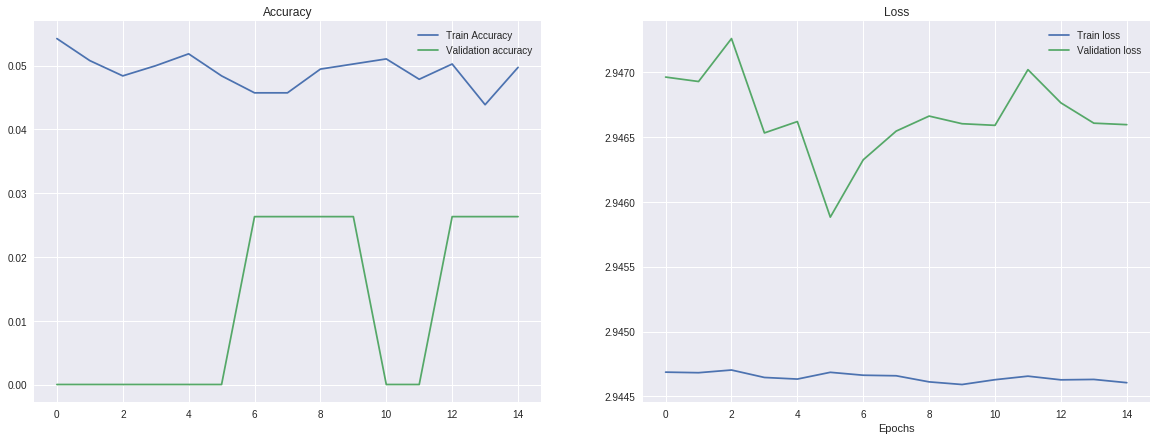

In [75]:
plot_metrics_primary(history.history['acc'], history.history['val_acc'], history.history['loss'], history.history['val_loss'])


In [86]:
# print(np.argmax(y_val, axis=1))
# print(model.predict_classes(x_val))
cnf_matrix = confusion_matrix(np.argmax(y_val, axis=1), model.predict_classes(x_val))
# print(cnf_matrix)
print(classes_name)
# plot_confusion_matrix(cnf_matrix, classes_names)

NameError: ignored

#Test


In [0]:
# Transform drawing into numpy arrays.
test['drawing_np'] = test['drawing'].apply(drawing_to_np)
# Reshape arrays.
test_drawings = np.asarray([x.reshape(HEIGHT, WIDTH, CHANNEL) for x in test['drawing_np'].values])

In [0]:
predictions = model.predict(test_drawings)
top_3_predictions = np.asarray([np.argpartition(pred, -3)[-3:] for pred in predictions])
top_3_predictions = ['%s %s %s' % (classes_names[pred[0]], classes_names[pred[1]], classes_names[pred[2]]) for pred in top_3_predictions]
test['word'] = top_3_predictions

In [0]:
submission = test[['key_id', 'word']]
submission.to_csv(SUBMISSION_NAME, index=False)
submission.head()

# Image to Array


In [1]:
# one way
examples = [ast.literal_eval(e) for e in data['drawing'][:15].values]
fig, ax = plt.subplots(1,15,figsize=(20,2))
for i, example in enumerate(examples[:15]):
    for x, y in example:
        ax[i].plot(x, y, marker='.', markersize=1, lw=3)
        ax[i].invert_yaxis()
        ax[i].axis('off')
#plt.close('all')
#plt.gcf()


NameError: ignored

In [0]:
# second way
def draw_it(raw_strokes):
    image = Image.new("P", (255,255), color=255)
    image_draw = ImageDraw.Draw(image)

    for stroke in eval(raw_strokes):
        for i in range(len(stroke[0])-1):

            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=6)
            image.show()
    return np.array(image)
img = draw_it(data_mat[0])

In [0]:
# third way
def drawing_to_np(drawing, shape=(28, 28)):
    # evaluates the drawing array
    drawing = eval(drawing)
    fig, ax = plt.subplots()
    for x,y in drawing:
        ax.plot(x, y, marker='.')
        ax.axis('off')        
    fig.canvas.draw()
    # Close figure so it won't get displayed while transforming the set
    plt.close(fig)
    # Convert images to numpy array
    np_drawing = np.array(fig.canvas.renderer._renderer)
    # Take only one channel
    np_drawing =np_drawing[:, :, 1]    
    # Normalize data
    np_drawing = np_drawing / 255.
    return cv2.resize(np_drawing, shape) # Resize array
